# Image segmentation
## 1.import module

In [1]:
import tensorflow as tf

import tensorflow_addons as tfa

from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow_examples.models.pix2pix.pix2pix import upsample
from tensorflow_examples.models.pix2pix.pix2pix import downsample

import tensorflow_advanced_segmentation_models as tasm

from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np

import os

from IPython.display import clear_output

from LoadData import Lab2DataLoader

## 2.load data and test data

In [2]:
train_img, test_img, color_codes = Lab2DataLoader().loadData()
INPUT_SHAPE = train_img['image'].shape[1:]
TRAIN_LENGTH = train_img['image'].shape[0]
TEST_LENGTH = test_img['image'].shape[0]
CLASSES = color_codes.shape[0]

cmap = colors.ListedColormap(color_codes / 255.0, "color_codes")
norm = colors.BoundaryNorm(np.arange(0, CLASSES), cmap.N)

print(f'dataset shape: train {train_img["image"].shape} test {test_img["image"].shape}')

dataset shape: train (2975, 128, 256, 3) test (500, 128, 256, 3)


### 2.1 buile tensorflow dataset

In [3]:
def normalize(image):
    image = tf.cast(image, tf.float32) / 255.0
    return image

### 2.2 Augment random horizontal flip

In [4]:
ratio = 1
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.Sequential([
            tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
            tf.keras.layers.RandomCrop(int(np.round(128*ratio)), int(np.round(256*ratio)), seed=seed),
            tf.keras.layers.Resizing(128,256,crop_to_aspect_ratio=True)
        ])
        self.augment_labels = tf.keras.Sequential([
            tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
            tf.keras.layers.RandomCrop(int(np.round(128*ratio)), int(np.round(256*ratio)), seed=seed),
            tf.keras.layers.Resizing(128,256,crop_to_aspect_ratio=True)
        ])

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [5]:
def load_image(dataset):
    input_image = tf.image.resize(dataset['image'], INPUT_SHAPE[:-1])
    input_mask = tf.image.resize(dataset['mask'], INPUT_SHAPE[:-1])
    input_image, input_mask = normalize(input_image), input_mask

    return input_image, input_mask

In [6]:
BATCH_SIZE = 16
BUFFER_SIZE = 1000
# STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_img)
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = (
    train_dataset
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .map(Augment())
        .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_dataset = tf.data.Dataset.from_tensor_slices(test_img)
test_dataset = (
    test_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(BATCH_SIZE)
)

print(train_dataset)

<PrefetchDataset shapes: ((None, 128, 256, 3), (None, 128, 256, 1)), types: (tf.float32, tf.float32)>


### 2.3 display mask image

In [8]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        if i == 0:
            plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        else:
            plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap=cmap)
            # plt.colorbar()
        plt.axis('off')
    plt.show()

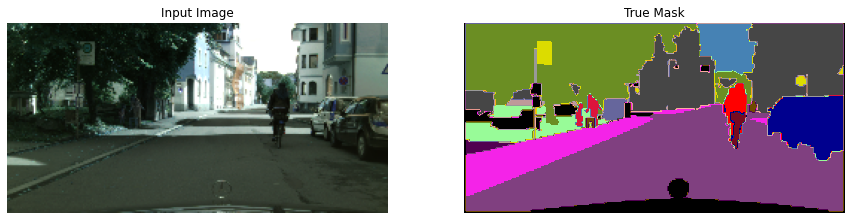

In [9]:
for images, masks in train_dataset.take(1):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

## 3.Define the model
[U-Net](https://arxiv.org/abs/1505.04597) encoder (downsampler) and decoder (upsampler)

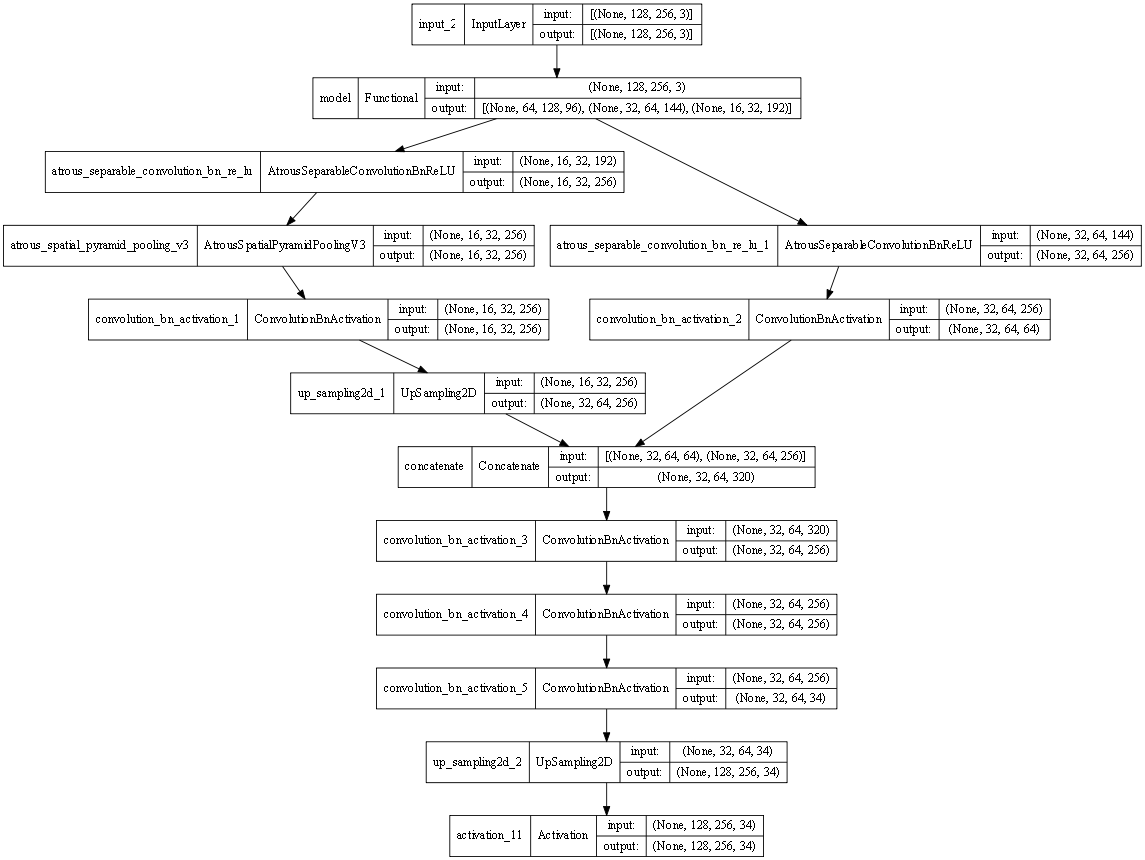

In [10]:
from UNet import UNet

BACKBONE_NAME = 'mobilenetv2'
WEIGHTS = 'imagenet'
HEIGHT = INPUT_SHAPE[0]
WIDTH = INPUT_SHAPE[1]
base_model, layers, layer_names = tasm.create_base_model(name=BACKBONE_NAME, weights=WEIGHTS, height=HEIGHT,
                                                         width=WIDTH, include_top=False)
model = tasm.DeepLabV3plus(n_classes=CLASSES, base_model=base_model, output_layers=layers, backbone_trainable=False,
                           # up_filters = [64, 128, 256, 512, 1024],
                           height=HEIGHT, width=WIDTH
                           )
# .model()

x = tf.keras.layers.Input(shape=(HEIGHT, WIDTH, 3))
model = tf.keras.Model(inputs=[x], outputs=model.call(x))

SparseCategoricalCrossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# x = tf.keras.layers.Input(shape=(HEIGHT, WIDTH, 3))
# model = tf.keras.Model(inputs=[x], outputs=model.call(x))

model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy,
              metrics=[tasm.metrics.IOUScore(threshold=0.5), 'accuracy'])

model._name = f'DeepLabV3plus_{BACKBONE_NAME}'
tf.keras.utils.plot_model(model,
                          # expand_nested=True,
                          show_shapes=True, dpi=64)

In [11]:
# tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)
model.summary()
# base_model.summary()

Model: "DeepLabV3plus_mobilenetv2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 128, 96  65920       ['input_2[0][0]',                
                                ),                                'input_2[0][0]']                
                                 (None, 32, 64, 144                                               
                                ),                                                                
                                 (None, 16, 32, 192                       

## 4.Train the model

In [12]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [13]:
def show_predictions(dataset=None, random=True, num=1):
    picker = 0
    if random:
        dataset = dataset.shuffle(BUFFER_SIZE)
    if dataset:
        for image, mask in dataset.take(num):
            if random:
                picker = np.random.randint(0, len(image))
            pred_mask = model.predict(image[picker][tf.newaxis, ...])
            display([image[picker], mask[picker], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [14]:
print(model.predict(sample_image[tf.newaxis, ...]).shape)

(1, 128, 256, 34)


### Test show prediction
display prediction in training

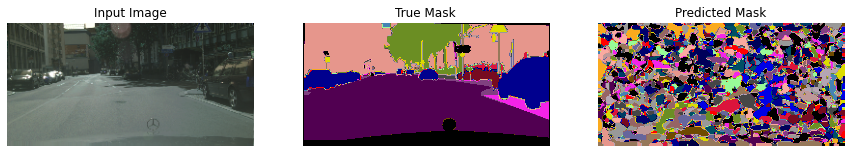

In [15]:
show_predictions(dataset=test_dataset)

### TensorBoard

In [16]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime

In [17]:
checkpoint_directory = "./training_checkpoints"
checkpoint_name = "ckpt"
checkpoint = tf.train.Checkpoint(model=model)
manager = tf.train.CheckpointManager(checkpoint,
                                     f'checkpoint_directory/{model.name}/',
                                     checkpoint_name=checkpoint_name,
                                     max_to_keep=5)

In [18]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(dataset=test_dataset, random=False)
        manager.save()
        print('\nSample Prediction after epoch {}\n'.format(epoch + 1))

In [19]:
def train(model, manager, EPOCH=20):
    checkpoint.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print(f"Restored from {manager.latest_checkpoint}")
    else:
        print("Initializing Model.")

    initial_epoch = checkpoint.save_counter.numpy()

    log_dir = f"./logs/{model.name}/"
    time_str = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir + time_str, histogram_freq=1)

    model_history = model.fit(train_dataset, epochs=EPOCH + initial_epoch,
                              # steps_per_epoch=STEPS_PER_EPOCH,
                              validation_data=test_dataset,
                              initial_epoch=initial_epoch,
                              # validation_steps=VALIDATION_STEPS,
                              callbacks=[DisplayCallback(), tensorboard_callback])


train(model, manager)

Restored from checkpoint_directory/DeepLabV3plus_mobilenetv2/ckpt-120
Layer AtrousSeparableConvolutionBnReLU has arguments ['self', 'filters', 'kernel_size', 'strides', 'padding', 'data_format', 'dilation', 'channel_multiplier', 'axis', 'momentum', 'epsilon', 'center', 'scale', 'post_activation', 'block_name']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config


E:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 121/140


InvalidArgumentError:  Shapes of all inputs must match: values[0].shape = [524288] != values[1].shape = [17825792]
	 [[node confusion_matrix/stack_1
 (defined at E:\ProgramData\Anaconda3\lib\site-packages\keras\metrics.py:3087)
]] [Op:__inference_train_function_12729]

Errors may have originated from an input operation.
Input Source operations connected to node confusion_matrix/stack_1:
In[0] confusion_matrix/control_dependency_2:	
In[1] confusion_matrix/control_dependency_3:

Operation defined at: (most recent call last)
>>>   File "E:\ProgramData\Anaconda3\lib\runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "E:\ProgramData\Anaconda3\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "E:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "E:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "E:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "E:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "E:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "E:\ProgramData\Anaconda3\lib\asyncio\events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "E:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "E:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "E:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "E:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "E:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "E:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "E:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "E:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "E:\ProgramData\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "E:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "E:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "E:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\jakoz\AppData\Local\Temp/ipykernel_15284/2955332119.py", line 23, in <module>
>>>     train(model, manager)
>>> 
>>>   File "C:\Users\jakoz\AppData\Local\Temp/ipykernel_15284/2955332119.py", line 15, in train
>>>     model_history = model.fit(train_dataset, epochs=EPOCH + initial_epoch,
>>> 
>>>   File "E:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "E:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "E:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "E:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "E:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "E:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 817, in train_step
>>>     self.compiled_metrics.update_state(y, y_pred, sample_weight)
>>> 
>>>   File "E:\ProgramData\Anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 460, in update_state
>>>     metric_obj.update_state(y_t, y_p, sample_weight=mask)
>>> 
>>>   File "E:\ProgramData\Anaconda3\lib\site-packages\keras\utils\metrics_utils.py", line 73, in decorated
>>>     update_op = update_state_fn(*args, **kwargs)
>>> 
>>>   File "E:\ProgramData\Anaconda3\lib\site-packages\keras\metrics.py", line 177, in update_state_fn
>>>     return ag_update_state(*args, **kwargs)
>>> 
>>>   File "E:\ProgramData\Anaconda3\lib\site-packages\keras\metrics.py", line 3087, in update_state
>>>     current_cm = tf.math.confusion_matrix(
>>> 

In [ ]:
% tensorboard --logdir logs / fit

In [28]:
for layer in model.layers:
    layer.trainable = True

    print(layer.name + ": " + str(layer.trainable))

input_8: True
model_3: True
atrous_separable_convolution_bn_re_lu_15: True
atrous_spatial_pyramid_pooling_v3_3: True
atrous_separable_convolution_bn_re_lu_16: True
convolution_bn_activation_19: True
convolution_bn_activation_20: True
up_sampling2d_10: True
concatenate_3: True
convolution_bn_activation_21: True
convolution_bn_activation_22: True
convolution_bn_activation_23: True
up_sampling2d_11: True
activation_47: True


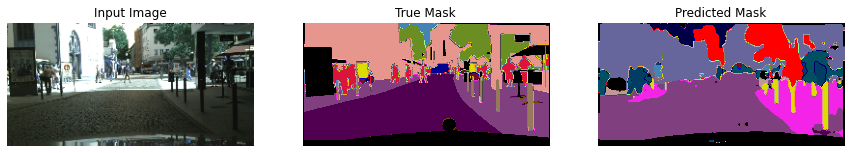


Sample Prediction after epoch 40

186/186 [==============================] - 11s 58ms/step - loss: 0.4024 - iou_score: 0.0359 - accuracy: 0.8806 - val_loss: 0.6840 - val_iou_score: 0.0353 - val_accuracy: 0.8212


In [29]:
train(model, manager)

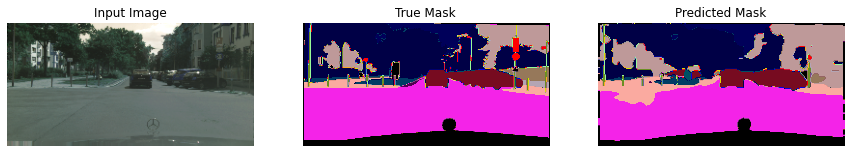

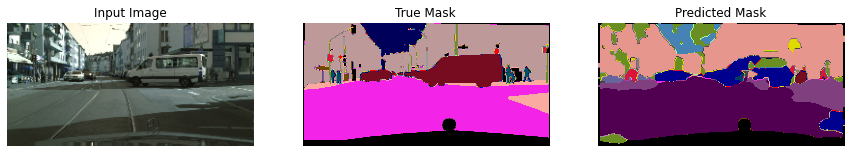

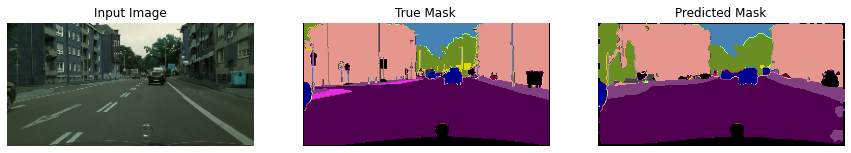

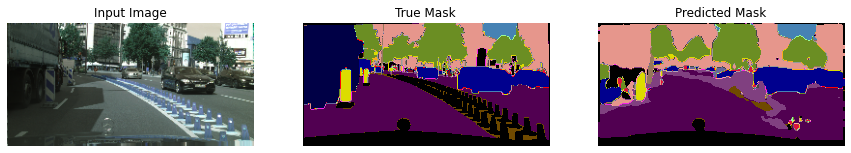

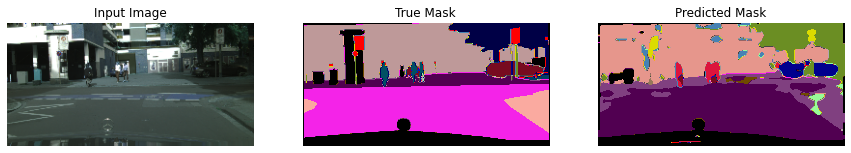

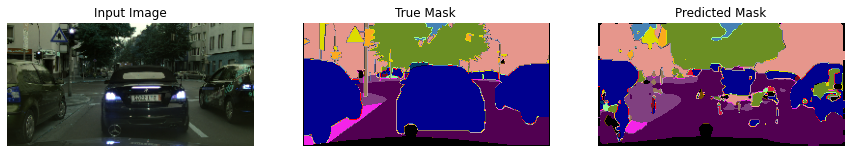

In [31]:
show_predictions(test_dataset, num=3)
show_predictions(train_dataset, num=3)